# Modelling Magnetar Bursts with MCMC

A simple code running MCMC on single spikes.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
import astropy.modeling.models as models
from astropy.modeling.models import custom_model

from stingray.modeling.posterior import PoissonLogLikelihood, PoissonPosterior
from stingray.modeling.parameterestimation import ParameterEstimation

Okay, let's first construct a model:

In [2]:
@custom_model
def BurstShape(x, t0=1.0, log_amplitude=0.0, tau=0.1, skew=1.0):
    
    x = np.array(x)
    mask_low = (x < t0)
    mask_high = (x >= t0)
    
    profile = np.zeros_like(x)
    
    amplitude = np.exp(log_amplitude)
    
    profile[mask_low] = amplitude * np.exp((x[mask_low]-t0)/tau)
    profile[mask_high] = amplitude * np.exp((t0-x[mask_high])/(tau*skew))
    
    return profile

Let's test it:

In [3]:
x = np.linspace(0,2, 1000)
mm = BurstShape(log_amplitude=2, t0=0.8, tau=0.1, skew=3)

mean_model = mm(x)

<IPython.core.display.Javascript object>


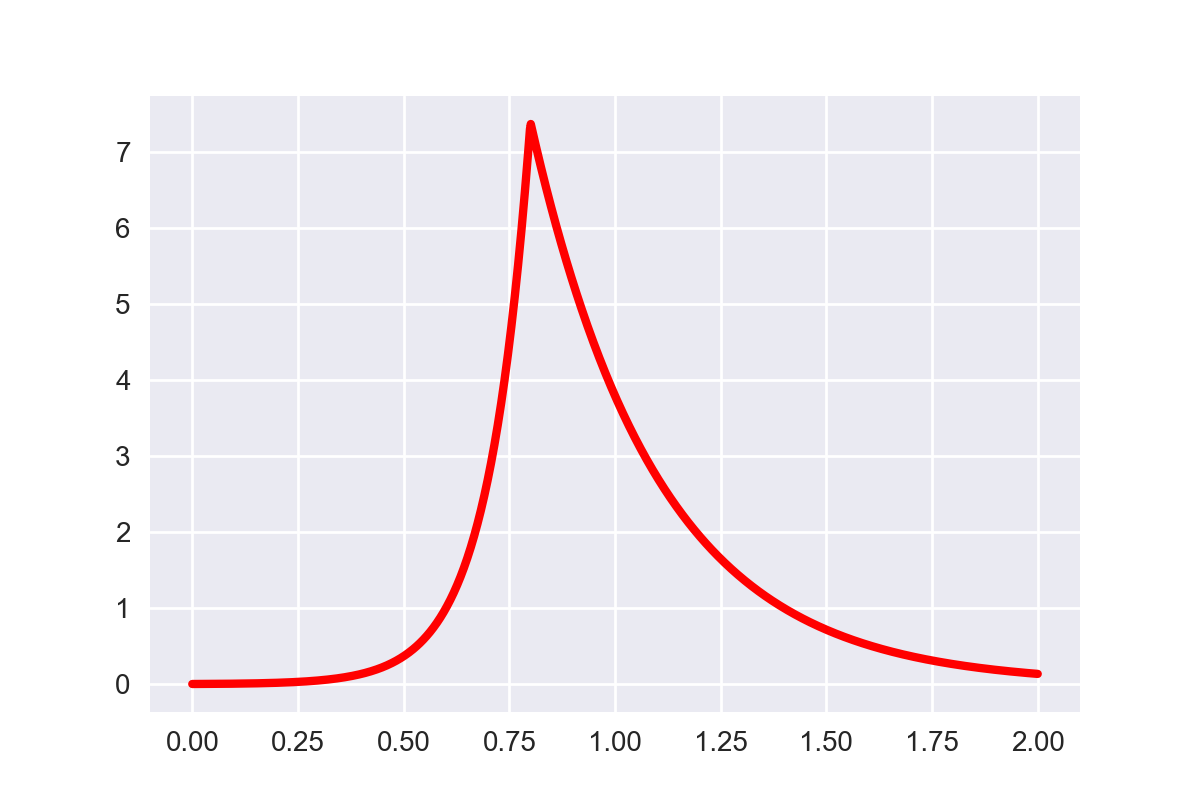

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(x, mean_model, lw=3, color="red")

Yup, that looks like a burst. Excellent, now let's use this to create some (fake) data, by also including a background:

In [5]:
@custom_model
def LogConst1D(x, log_amplitude=0.0):
    return np.ones_like(x) * np.exp(log_amplitude)

In [6]:
mm = BurstShape() + LogConst1D()

In [7]:
true_const_amplitude = np.log(10)
true_log_amplitude = np.log(100)
true_t0 = 0.8
true_tau = 0.1
true_skew = 3.0

In [8]:
mm.param_names

('t0_0', 'log_amplitude_0', 'tau_0', 'skew_0', 'log_amplitude_1')

In [9]:
true_params = [true_t0, true_log_amplitude, true_tau, true_skew, true_const_amplitude]

In [10]:
mm.log_amplitude_1 = true_const_amplitude
mm.log_amplitude_0 = true_log_amplitude
mm.t0_0 = true_t0
mm.tau_0 = true_tau
mm.skew_0 = true_skew

In [11]:
true_model = mm(x)

In [12]:
rng = np.random.RandomState()

In [13]:
counts = rng.poisson(true_model)

<IPython.core.display.Javascript object>


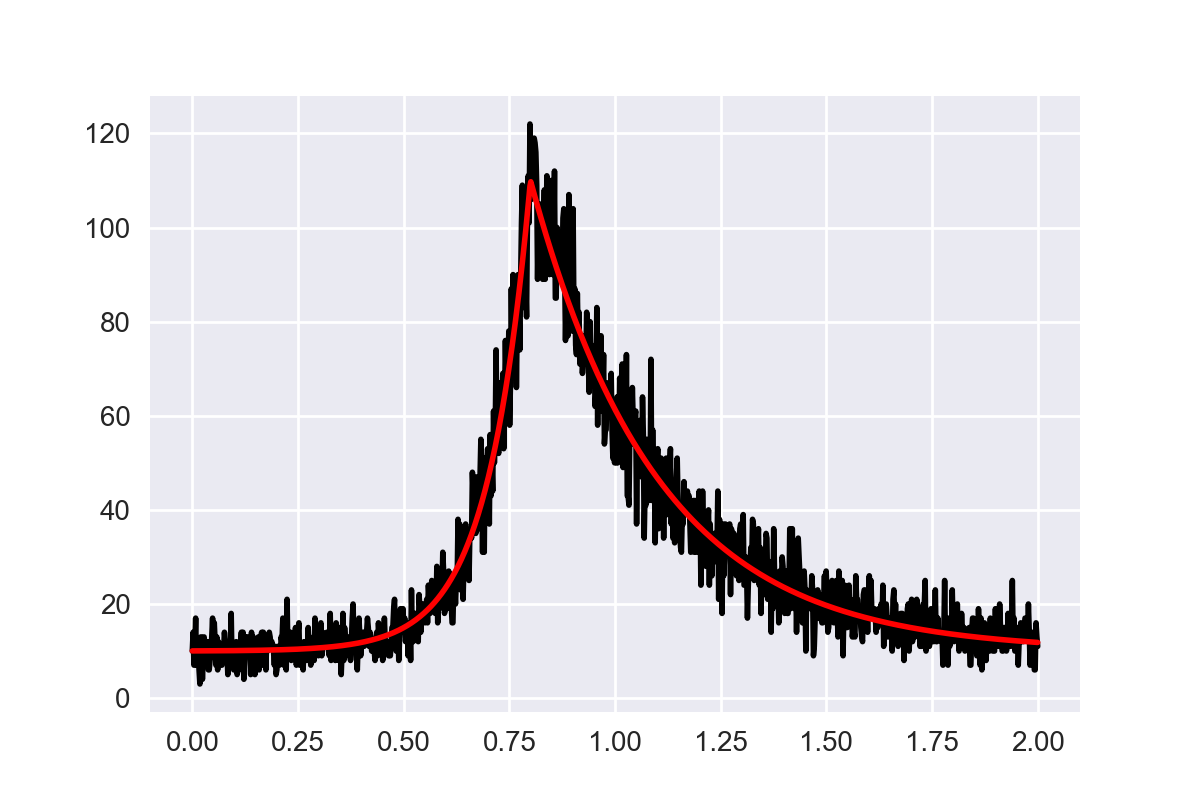

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(x, counts, lw=2, color="black", label="Simulated data")
ax.plot(x, true_model, lw=2, color="red", label="True model")

Ok, cool. Now we can set up a Poisson likelihood for a Maximum Likelihod fit:

In [15]:
loglike = PoissonLogLikelihood(x, counts, mm)

In [16]:
mm.param_names

('t0_0', 'log_amplitude_0', 'tau_0', 'skew_0', 'log_amplitude_1')

Let's make a dumb guess about the position of the peak, by finding the position where the counts array has its maximum:

In [17]:
t0_guess = x[np.argsort(counts)[::-1]][0]
t0_guess

0.79879879879879878

Let's also make a similarly dumb assumption for the log amplitude of the burst:

In [18]:
log_amp_guess = np.log(np.mean(np.sort(counts)[::-1][:10]))
log_amp_guess

4.746669748261791

Finally, a guess for the background:

In [19]:
bkg_amp_guess = np.log(np.mean(np.hstack([counts[:10], counts[-10:]])))

In [20]:
bkg_amp_guess

2.3223877202902252

These guesses are already pretty close to the true values, which is nice:

In [21]:
start_pars = [t0_guess, log_amp_guess, 0.2, 1.0, bkg_amp_guess]

In [22]:
loglike(start_pars)

-5397.039810673059

In [23]:
loglike(true_params)

-2969.5387765514861

Okay, so at least the likelihood of my true underlying parameters is higher than the starting samples, which are a bit further away, because I also guessed pretty wrong for the rise time and the skewness.

Let's now try to fit this using maximum likelihood:

In [24]:
parest = ParameterEstimation(max_post=False)

In [25]:
res = parest.fit(loglike, start_pars, neg=True)

What are the best-fit parameters?

In [26]:
res.p_opt

array([ 0.79980401,  4.60877983,  0.09810518,  3.06902052,  2.32699734])

What's the covariance of these parameters?

In [27]:
res.cov

array([[  6.23580487e-06,  -2.69619887e-05,   7.09245385e-07,
          5.00465345e-06,   9.65444592e-06],
       [ -2.69619887e-05,   2.96763182e-04,  -9.93394941e-06,
         -6.60004003e-05,  -1.27031396e-04],
       [  7.09245385e-07,  -9.93394941e-06,   1.01035017e-06,
          2.16670004e-06,   3.82805582e-06],
       [  5.00465345e-06,  -6.60004003e-05,   2.16670004e-06,
          1.57739869e-05,   3.04625865e-05],
       [  9.65444592e-06,  -1.27031396e-04,   3.82805582e-06,
          3.04625865e-05,   5.90131170e-05]])

Looking pretty good! Okay, to set up MCMC, we're going to need everyone's least favourite concept: priors. In short,
MCMC can't be run on the likelihood, because the likelihood isn't a normalized probability distribution, and all guarantees about convergence go to hell. 

So let's define some (boring, uninformative) priors:

In [28]:
import scipy.stats

In [29]:

# exponential prior for the amplitude between some fairly wide boundaries
p_log_amplitude = lambda logamp: scipy.stats.uniform(np.log(0.01), (np.log(10000)-np.log(0.01))).pdf(logamp)

# t0 can be uniformely anywhere between the start and end of the light curve
min_x = x[0]
max_x = x[-1]
p_t0 = lambda t0: scipy.stats.uniform(min_x, (max_x - min_x)).pdf(t0)

# tau can be somewhere between a fraction of the time resolution and the duration of the light curve
min_tau = np.diff(x)[0]/10.0
max_tau = max_x - min_x
p_tau = lambda tau: scipy.stats.uniform(min_tau, (max_tau - min_tau)).pdf(tau)

# skew can be anywhere between -20 and 20:
min_skew = -20
max_skew = 20
p_skew = lambda skew: scipy.stats.uniform(min_skew, (max_skew - min_skew)).pdf(skew)

# log background amplitude is another exponential distribution same as burst amplitude
p_log_bkg_amplitude = lambda log_bkg: scipy.stats.uniform(np.log(0.01), (np.log(10000)-np.log(0.01))).pdf(log_bkg)

# make a dictionary of the type {param_name: prior}
priors = {"log_amplitude_0": p_log_amplitude,
          "log_amplitude_1": p_log_bkg_amplitude,
          "t0_0": p_t0,
          "tau_0": p_tau,
          "skew_0": p_skew}





Okay, now we can set up our Posterior object:

In [30]:
lpost = PoissonPosterior(x, counts, mm, priors=priors)

Let's try:

In [31]:
lpost(start_pars)

-5407.3664682121344

In [32]:
lpost(true_params)

-2979.8654340905614

Okay, this seems to work. We are going to redo the fitting (this time it's going to be the Maximum-A-Posteriori fit, i.e. with priors) so that we can stick the results into MCMC:

In [33]:
parest = ParameterEstimation(max_post=True)

In [34]:
res = parest.fit(lpost, start_pars, neg=True)

In [35]:
res.p_opt

array([ 0.79980401,  4.60877986,  0.0981052 ,  3.06901996,  2.32699731])

Again, this is a pretty good solution. Now we want to run MCMC, so let's go ahead with that:

In [36]:
sample_res = parest.sample(lpost, res.p_opt, cov=res.cov, nwalkers=100, niter=1000, burnin=100, threads=1)

Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.553630.5
R_hat for the parameters is: [  4.16579863e-06   1.52363406e-04   6.86091725e-06   7.09387286e-03
   4.56393506e-04]
-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

theta[0] 	 0.800103282911	0.0020413911871	0.793650645514	0.795359501018

theta[1] 	 4.60863101137	0.0123453412117	4.56815678305	4.57950674104

theta[2] 	 0.0983625609895	0.00261992477088	0.0901156542294	0.0923998695009

theta[3] 	 3.06145396312	0.0842412622268	2.79797167368	2.86915212197

theta[4] 	 2.32660043573	0.0213677145844	2.25653708948	2.27544503609



In [38]:
import corner

In [39]:
mm.param_names

('t0_0', 'log_amplitude_0', 'tau_0', 'skew_0', 'log_amplitude_1')

<IPython.core.display.Javascript object>


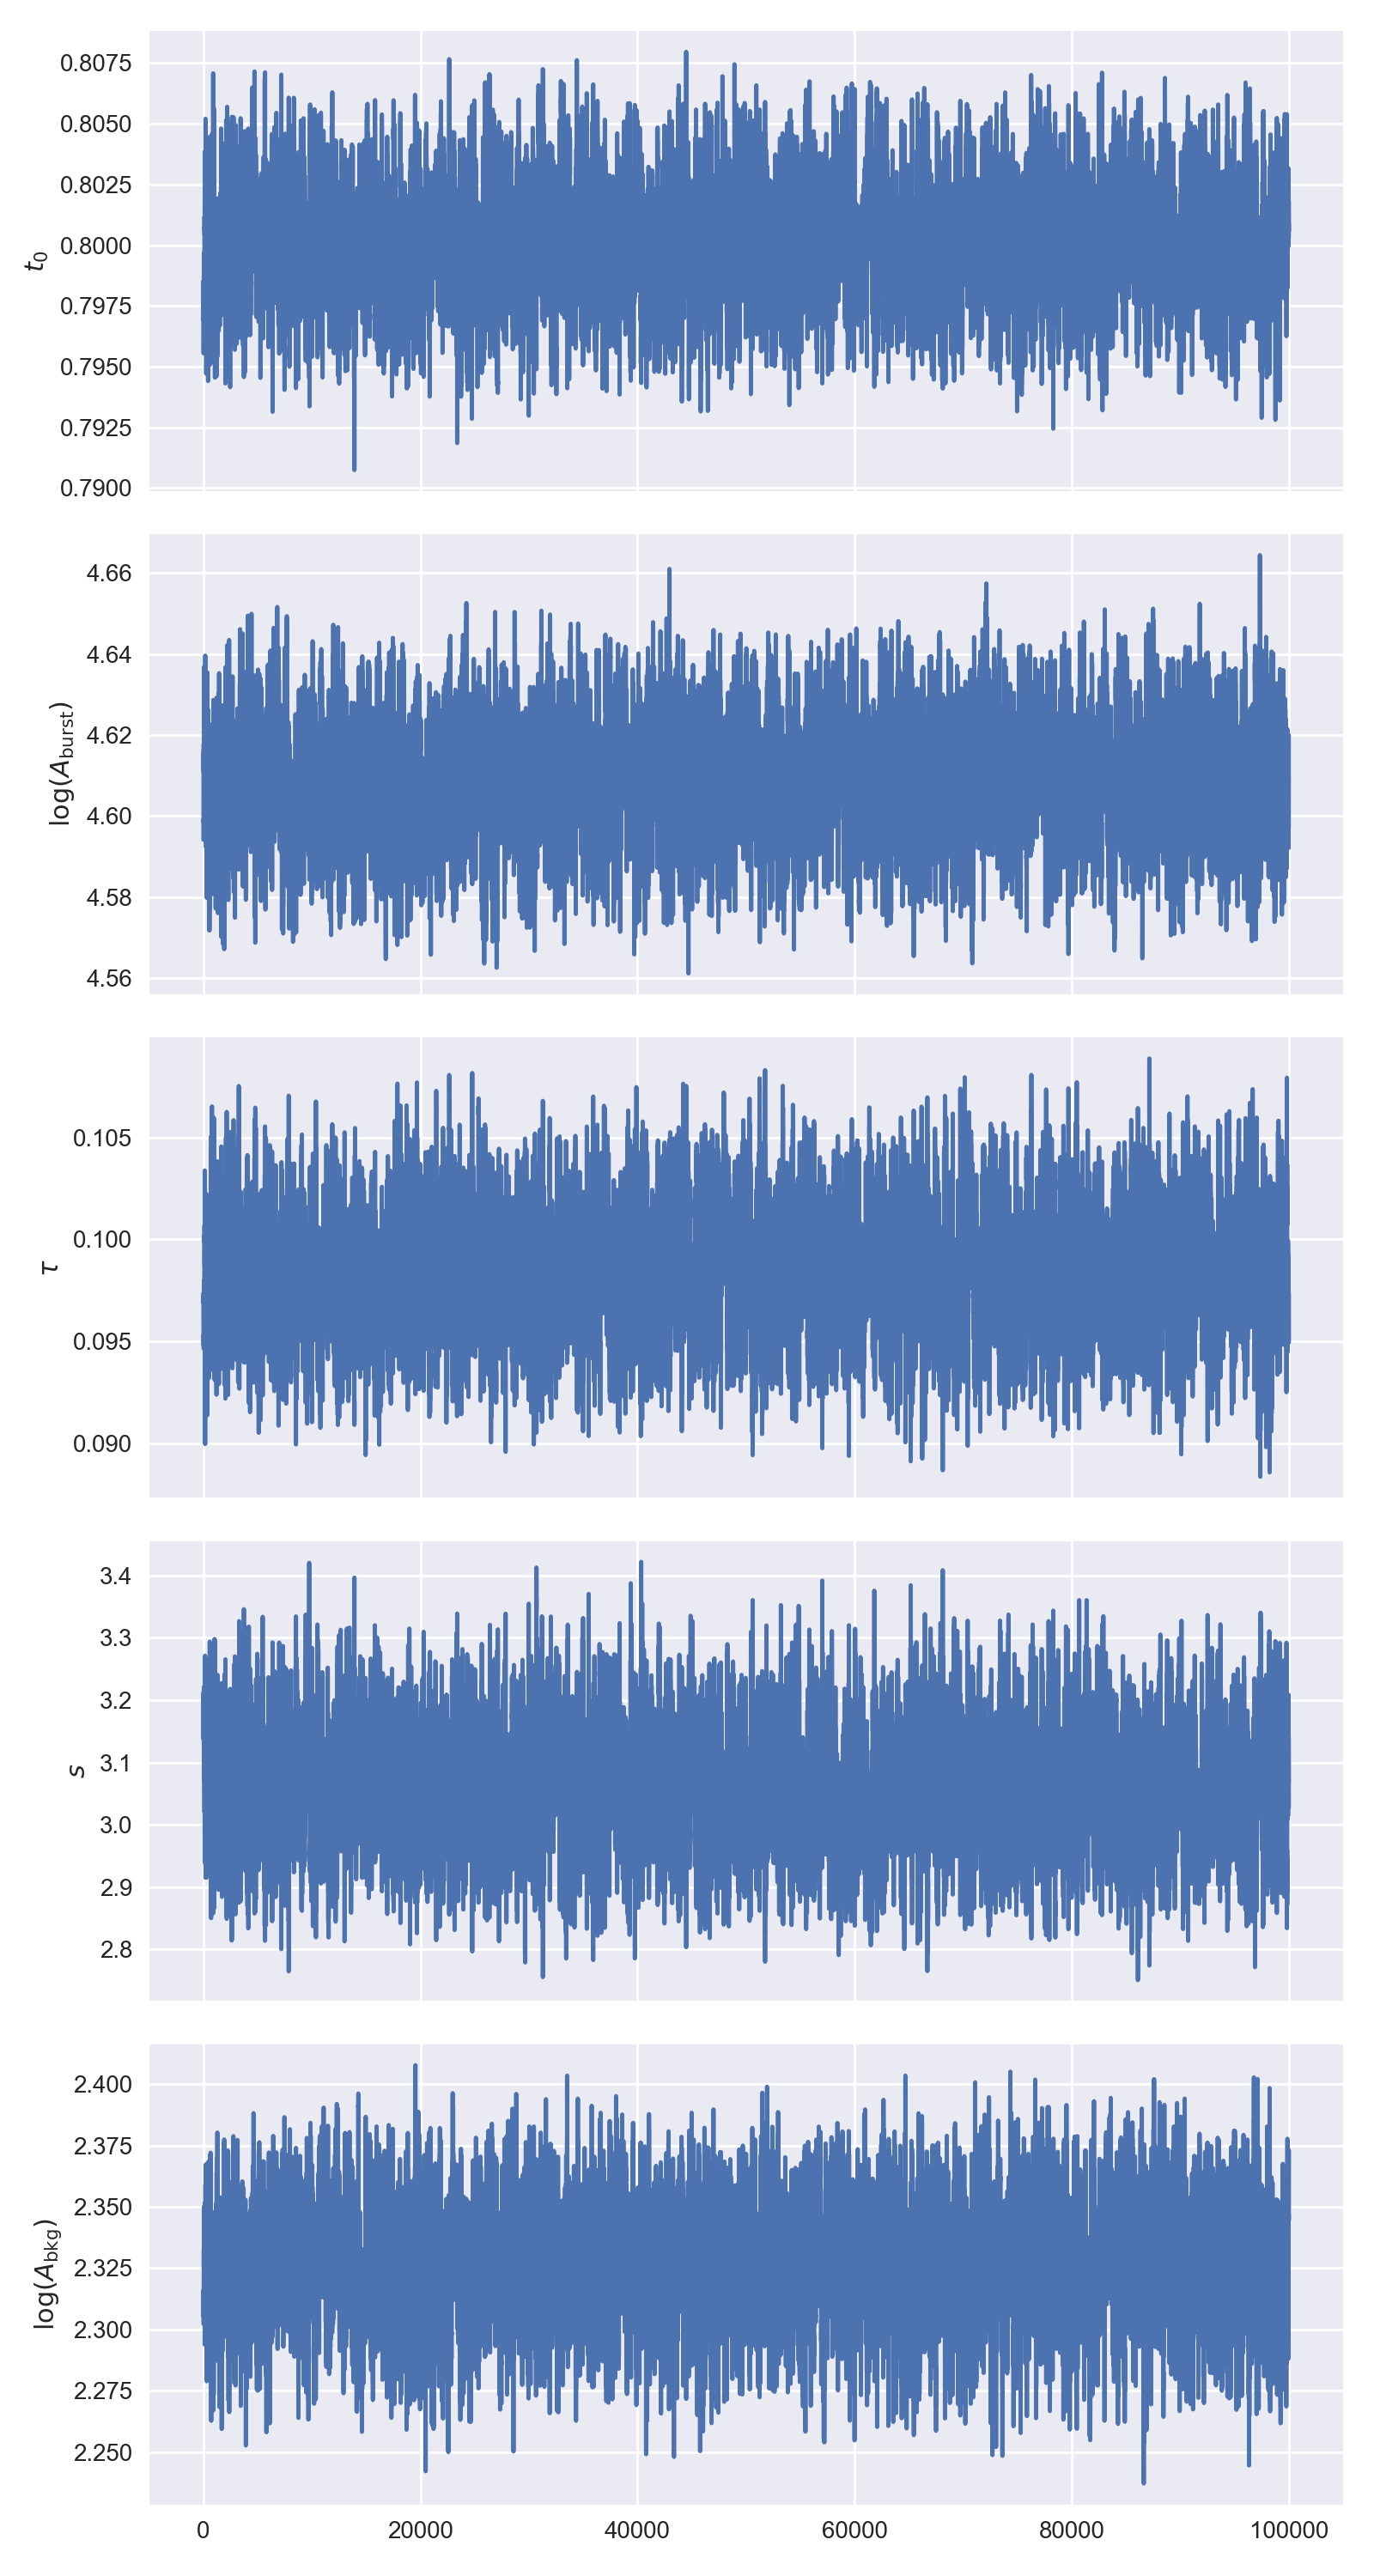

In [40]:
ndim = sample_res.samples.shape[1]

fig, axes = plt.subplots(ndim, 1, figsize=(8,3*ndim), sharex=True)
axes = np.hstack(axes)

param_names = [r"$t_0$", r"$\log(A_{\mathrm{burst}})$", 
               r"$\tau$", r"$s$", r"$\log(A_{\mathrm{bkg}})$"]

for i in range(sample_res.samples.shape[1]):
    axes[i].plot(sample_res.samples[:,i])
    axes[i].set_ylabel(param_names[i])

plt.tight_layout()

In [41]:
sample_res.acceptance

0.55363000000000007

<IPython.core.display.Javascript object>


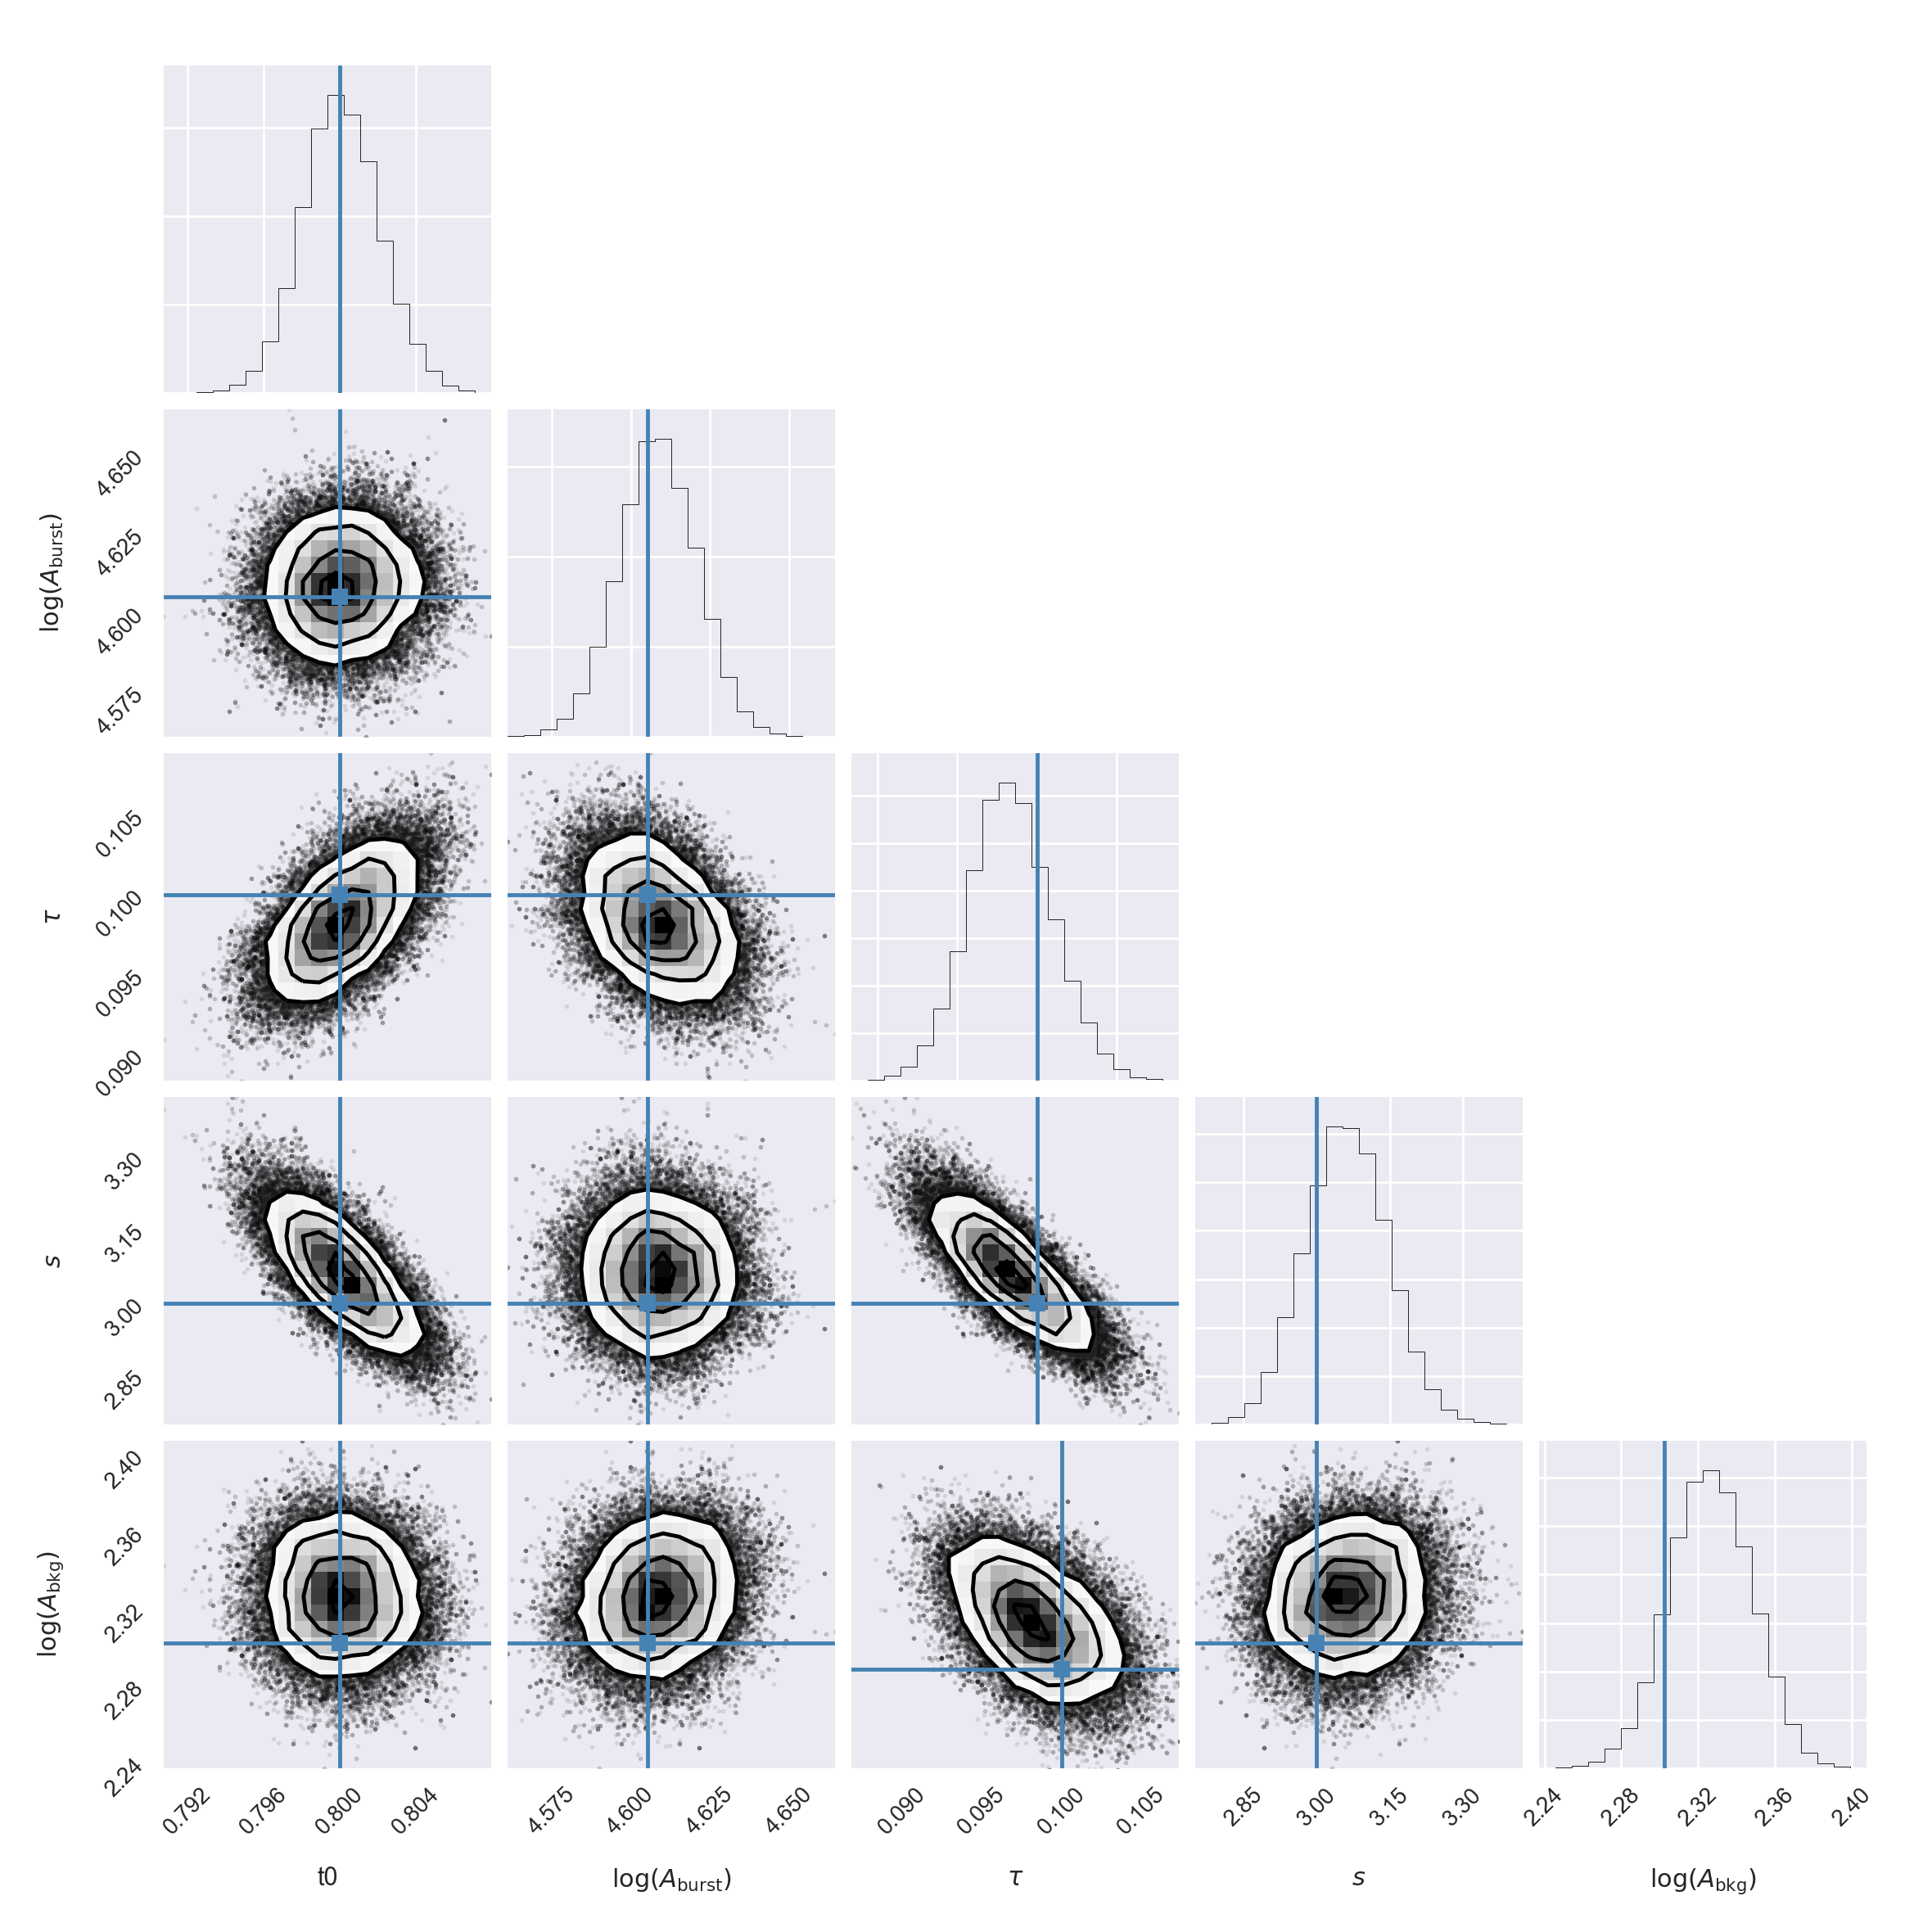

In [42]:
corner.corner(sample_res.samples, labels=["t0", r"$\log(A_{\mathrm{burst}})$", 
                                          r"$\tau$", r"$s$", r"$\log(A_{\mathrm{bkg}})$"],
              truths = true_params);

That looks pretty good. The distributions don't match exactly the values we put in, but the posteriors are pretty narrow and well-behaved, and they are close enough for me to think that the discrepancies are just due to the Poisson noise I stuck in.

I've put the whole procedure into a command line script that can deal with both single and multiple bursts. 
Let's try it out! 

First, let's save the file above to disk, and also make a couple of other bursts with different parameters:

In [145]:
np.savetxt("./testburst1.txt", np.array([x, counts]).T)

And a couple of other simulated bursts:

In [158]:
mm.log_amplitude_1 = np.log(10)
mm.log_amplitude_0 = np.log(40)
mm.t0_0 = 1.1
mm.tau_0 = 0.05
mm.skew_0 = 10

In [159]:
mean_model2 = mm(x)
counts2 = rng.poisson(mean_model2)

In [163]:
mm.log_amplitude_1 = np.log(10)
mm.log_amplitude_0 = np.log(1000)
mm.t0_0 = 1.0
mm.tau_0 = 0.2
mm.skew_0 = 1

In [164]:
mean_model3 = mm(x)
counts3 = rng.poisson(mean_model3)

<IPython.core.display.Javascript object>


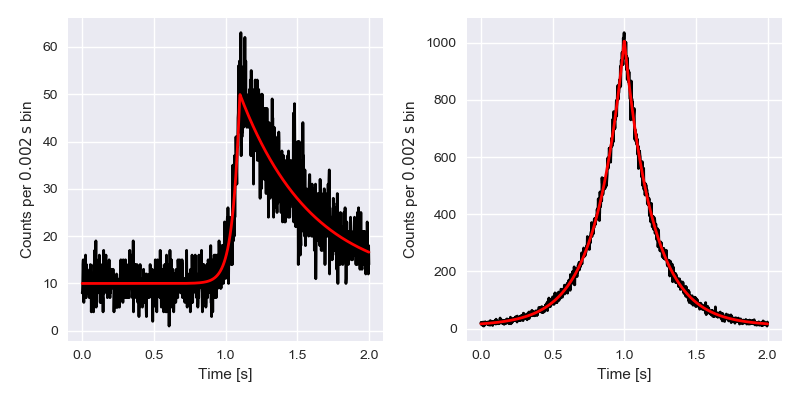

In [169]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.plot(x, counts2, lw=2, color="black", label="Simulated data")
ax1.plot(x, mean_model2, lw=2, color="red", label="True model")

ax2.plot(x, counts3, lw=2, color="black", label="Simulated data")
ax2.plot(x, mean_model3, lw=2, color="red", label="True model")

ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Counts per $0.002\,\mathrm{s}$ bin")

ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Counts per $0.002\,\mathrm{s}$ bin")

plt.tight_layout()


Let's save these two data sets to file, too:

In [170]:
np.savetxt("./testburst2.txt", np.array([x, counts2]).T)
np.savetxt("./testburst3.txt", np.array([x, counts3]).T)

Finally, let's make a file with the file names of all those data sets (note: use absolute paths!)

In [174]:
datadir = "/Users/danielahuppenkothen/work/repositories/burst_vs_phase_v2/"

files = np.array([datadir + "testburst1.txt",
                  datadir + "testburst2.txt",
                  datadir + "testburst3.txt",])

np.savetxt("burstlist.txt", files.T, fmt="%s")